### Install required libraries

In [1]:
!pip install -q gdown patool numpy pandas matplotlib torch torchvision timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.0/96.0 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 44.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 39.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 59.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━

In [26]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import time
import copy


import sys
from tqdm import tqdm

import gdown

from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

from timm.loss import LabelSmoothingCrossEntropy # This is better than normal nn.CrossEntropyLoss

%matplotlib inline

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Download training and validation data from Google Drive

In [5]:
file_id = "1ehyrYBQ5rbQQe6yL4XbLWe3FMvuVUGiL"
file_name = "Project_data.zip"

gdown.download(f"https://drive.google.com/uc?id={file_id}", file_name)

Downloading...
From (original): https://drive.google.com/uc?id=1ehyrYBQ5rbQQe6yL4XbLWe3FMvuVUGiL
From (redirected): https://drive.google.com/uc?id=1ehyrYBQ5rbQQe6yL4XbLWe3FMvuVUGiL&confirm=t&uuid=23b9ebc4-63a5-4328-923a-df04e7940ff5
To: /content/Project_data.zip
100%|██████████| 1.71G/1.71G [00:10<00:00, 160MB/s]


'Project_data.zip'

In [7]:
# Remove extracted files if already exist
!rm -rf 'Project_data'
!unzip -qq Project_data.zip

In [8]:
data_root_dir = "/content/Project_data"
train_images_dir = os.path.join(data_root_dir, 'train')
val_images_dir = os.path.join(data_root_dir, 'val')
train_csv_file = os.path.join(data_root_dir, 'train.csv')
val_csv_file = os.path.join(data_root_dir, 'val.csv')

In [9]:
train_data_df = pd.read_csv(train_csv_file)
df = pd.DataFrame(train_data_df.iloc[:, 0].str.split(';').tolist(), columns = ['folder', 'label','class'])
classes = df['class'].unique()

In [10]:
# Hyperparameters
num_epochs = 1
batch_size = 2
learning_rate = 0.001

In [15]:
class CustomVideoDataset(Dataset):

  def __init__(self, images_dir, data_file, transform):

    self.images_dir = images_dir
    self.transform = transform
    data_df = pd.read_csv(data_file)
    self.data = data_df.iloc[:, 0].str.split(';')

  def __len__(self):
    return len(self.data)

  def __getitem__(self, index):
    images = []
    images_path = os.path.join(self.images_dir, self.data[index][0])
    print(f'Loading video images from folder {images_path}')
    for image_file in os.scandir(images_path):
      image = Image.open(os.path.join(images_path, image_file))
      if self.transform:
        image = self.transform(image)
      images.append(image)

    label = self.data[index][2]

    X = torch.stack(images)
    y = torch.tensor(int(label), dtype=torch.long)

    return X, y


In [16]:
transform = transforms.Compose([
  transforms.Resize(224),
  transforms.ToTensor(),
  transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

train_dataset = CustomVideoDataset(train_images_dir, train_csv_file, transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, num_workers=1)

val_dataset = CustomVideoDataset(val_images_dir, val_csv_file, transform)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=1)

In [17]:
def inverse_normalize(tensor, mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)):
    mean = torch.as_tensor(mean, dtype=tensor.dtype, device=tensor.device)
    std = torch.as_tensor(std, dtype=tensor.dtype, device=tensor.device)
    if mean.ndim == 1:
        mean = mean.view(-1, 1, 1)
    if std.ndim == 1:
        std = std.view(-1, 1, 1)
    tensor.mul_(std).add_(mean)
    return tensor

Loading video images from folder /content/Project_data/train/WIN_20180925_17_18_28_Pro_Left_Swipe_new
Loading video images from folder /content/Project_data/train/WIN_20180925_17_18_56_Pro_Left_Swipe_new
Loading video images from folder /content/Project_data/train/WIN_20180925_17_19_51_Pro_Left_Swipe_new
Loading video images from folder /content/Project_data/train/WIN_20180925_17_20_14_Pro_Left_Swipe_new
Train images shape: torch.Size([2, 30, 3, 224, 298])


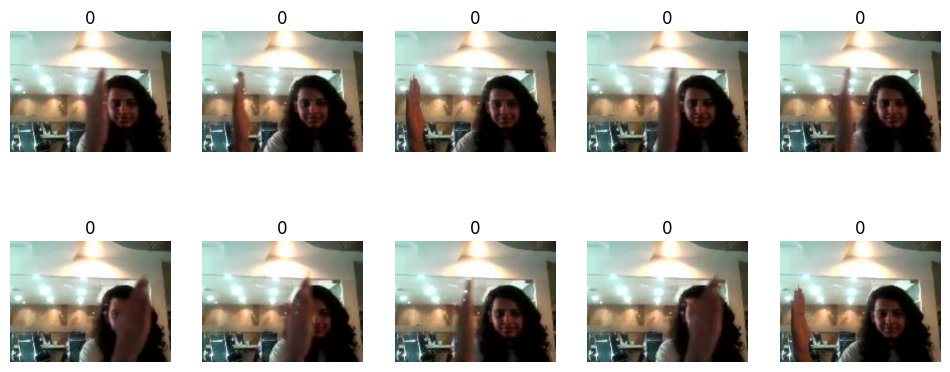

In [22]:
batch_of_video_image_frames, labels = next(iter(train_loader))
print(f'Train images shape: {batch_of_video_image_frames.shape}')

_, axs = plt.subplots(2, 5, figsize=(12, 5))

index = 0
for row in range(2):
  for col in range(5):
    input_tensor= inverse_normalize(tensor=batch_of_video_image_frames[0][index])
    img = input_tensor.squeeze(0)
    axs[row, col].imshow(transforms.ToPILImage()(img))
    axs[row, col].set_title(labels[0].item())
    axs[row, col].axis('off')
    index += 1

In [27]:
class CNNLSTM(nn.Module):
    def __init__(self, num_classes=5):
        super(CNNLSTM, self).__init__()
        self.resnet = models.resnet101(pretrained=True)
        self.resnet.fc = nn.Sequential(nn.Linear(self.resnet.fc.in_features, 300))
        self.lstm = nn.LSTM(input_size=300, hidden_size=256, num_layers=3)
        self.fc1 = nn.Linear(256, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x_3d):
        hidden = None

        # Iterate over each frame of a video in a video of batch * frames * channels * height * width
        for t in range(x_3d.size(1)):
            with torch.no_grad():
                x = self.resnet(x_3d[:, t])
            # Pass latent representation of frame through lstm and update hidden state
            out, hidden = self.lstm(x.unsqueeze(0), hidden)

        # Get the last hidden state (hidden is a tuple with both hidden and cell state in it)
        x = self.fc1(hidden[0][-1])
        x = F.relu(x)
        x = self.fc2(x)

        return x

In [28]:
model = CNNLSTM()
model.to(device)

criterion = LabelSmoothingCrossEntropy()
criterion = criterion.to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth
100%|██████████| 171M/171M [00:02<00:00, 88.4MB/s]


In [29]:
for epoch in range(num_epochs):
    model.train()

    running_loss = 0.0
    running_corrects = 0.0

    for i, (X, y) in enumerate(tqdm(train_loader)):
        optimizer.zero_grad()

        X = X.to(device)
        y = y.to(device)

        outputs = model(X)
        loss = criterion(outputs, y)

        preds = outputs.argmax(dim=1, keepdim=True)
        corrects = preds.eq(y.view_as(preds)).sum().item()
        running_loss += loss.item()
        running_corrects += corrects

        loss.backward()
        optimizer.step()

        print(f'Loss: {running_loss}, Acc: {running_corrects}')

  0%|          | 0/331 [00:00<?, ?it/s]

Loading video images from folder /content/Project_data/train/WIN_20180925_17_18_28_Pro_Left_Swipe_new
Loading video images from folder /content/Project_data/train/WIN_20180925_17_18_56_Pro_Left_Swipe_new
Loading video images from folder /content/Project_data/train/WIN_20180925_17_19_51_Pro_Left_Swipe_new
Loading video images from folder /content/Project_data/train/WIN_20180925_17_20_14_Pro_Left_Swipe_new
Loading video images from folder /content/Project_data/train/WIN_20180925_17_21_28_Pro_Left_Swipe_new
Loading video images from folder /content/Project_data/train/WIN_20180925_17_22_55_Pro_Left_Swipe_new


  0%|          | 1/331 [00:37<3:27:11, 37.67s/it]

Loading video images from folder /content/Project_data/train/WIN_20180925_17_24_49_Pro_Left_Swipe_new
Loss: 1.5671677589416504, Acc: 2.0
Loading video images from folder /content/Project_data/train/WIN_20180925_17_26_25_Pro_Left_Swipe_new


  1%|          | 2/331 [01:15<3:25:54, 37.55s/it]

Loading video images from folder /content/Project_data/train/WIN_20180925_17_26_51_Pro_Left_Swipe_new
Loss: 3.072009801864624, Acc: 4.0
Loading video images from folder /content/Project_data/train/WIN_20180925_17_27_40_Pro_Left_Swipe_new


  1%|          | 2/331 [01:32<4:12:14, 46.00s/it]


KeyboardInterrupt: 